Potential outcomes: theory and application

Sources:
- causal inference mixtape 
- Imbens book 
- Imbens review article JEL
- Dehejia/Wahba 2002. https://business.baylor.edu/scott_cunningham/teaching/dehejia-and-wahba-2002.pdf

I slightly adjusted the comparisons what made most sense for me in the present context but have not compared them all to the original sources.
Specifically, I tried to approximate as closely as possible a real situation where we do not have the experimental controls.

Context
- explain Dehejia/Wahba; Lalonde predecessor

In [264]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)



### Load data 

In [265]:
nsw_dw = read_data('nsw_mixtape.dta')
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')


In [266]:
nsw_dw.describe()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
count,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.415730,25.370787,10.195505,0.833708,0.08764,0.168539,0.782022,2102.265381,1377.138306,5300.764160
std,0.493402,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.582520,3150.960693,6631.491699
min,0.000000,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.812012
75%,1.000000,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.388916,1220.836060,8124.714844
max,1.000000,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.679688,25142.240234,60307.929688


Stack together; prepare more variables

In [267]:
# for differentiating groups later 
nsw_dw["random"] = 1 
nsw_dw_cpscontrol["random"] = 0

nsw_stacked = pd.concat((nsw_dw_cpscontrol, nsw_dw))

# unemployment 
nsw_stacked[["unemp74", "unemp75"]] = 0
nsw_stacked.loc[nsw_stacked.re74==0, 'unemp74'] = 1
nsw_stacked.loc[nsw_stacked.re75==0, 'unemp75'] = 1

# rename earnings
nsw_stacked = nsw_stacked.rename(columns={"re74": "earn74", "re75": "earn75", "re78": "earn78"})

In [268]:
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,random,unemp74,unemp75
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012592,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237305,13318.517578,14588.224609,0.027073,0.136217,0.123928
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637695,9372.831055,9702.608398,0.162301,0.343029,0.329509
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236084,3695.896973,5088.759766,0.000000,0.000000,0.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320312,14109.530273,15962.400391,0.000000,0.000000,0.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.339844,22703.080078,25564.669922,0.000000,0.000000,0.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.679688,25243.550781,60307.929688,1.000000,1.000000,1.000000


### Naive difference in means

- we take the treated from `nsw_dw` and the controls from `nsw_dw_cpscontrol` (ignore the controls from the experiment)

In [269]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["random"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["random"] == 0)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The non-experimental difference in raw means is {te1:.2f}")

The non-experimental difference in raw means is -8497.52


This number is the same as in Dehejia/Wahba 2022, table 2, row 2, second-last column

### Experimental estimate

We *do* have the experimental data, so let's see the estimate here.

In [270]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["random"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["random"] == 1)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The experimental difference in raw means is {te1:.2f}")

The experimental difference in raw means is 1794.34


### Sample selection

- discuss the formula/decomposition 
- could we just run a regression and control for the other observed characteristics?
- yes, but the potential outcome approach has the following benefits:
    - it makes us more aware of the required assumptions 
    - in some cases, regression may heavily interpolate between groups; using the methods discussed here put some more hurdles to prevent us from doing this


### Propensity score

- discuss the theorem 
- for discussing balance here, we'd need to match on closest neighbor 

In [271]:
# we'll ignore the experimental controls from now on.
drop = (nsw_stacked["random"] == 1) & (nsw_stacked["treat"] == 0)
nsw_stacked = nsw_stacked.loc[~drop, :]

mask_treat = nsw_stacked["treat"] == 1
mask_control = nsw_stacked["treat"] == 0

N_treat = nsw_stacked.loc[mask_treat, :].shape[0]
N_control = nsw_stacked.loc[mask_control, :].shape[0]

assert N_treat + N_control == nsw_stacked.shape[0], "some units got lost"

In [272]:
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + earn74 + earn75 + unemp74 + unemp75 + educ*earn74""", 
                    family=sm.families.Binomial(),
                   data=nsw_stacked).fit()
                  
nsw_stacked['pscore'] = logit_nsw.predict(nsw_stacked)

In [273]:
print(nsw_stacked.loc[mask_treat, "pscore"].describe())
print(nsw_stacked.loc[mask_control, "pscore"].describe())

count    185.000000
mean       0.425357
std        0.307691
min        0.001061
25%        0.132217
50%        0.400199
75%        0.670616
max        0.938455
Name: pscore, dtype: float64
count    1.599200e+04
mean     6.647637e-03
std      4.166721e-02
min      1.176785e-09
25%      1.927807e-05
50%      1.187187e-04
75%      9.633719e-04
max      9.239787e-01
Name: pscore, dtype: float64


The propensity scores are highly imbalanced, and there are a lot of units in the control group whose propensity score is below the minimum in the treatment group.
Since these units will not be contribute information to the estimation (they are not good "counterfactuals" because of their low propensity score), we drop them, like Dehejia/Wahba also did.

In [274]:
pscore_threshold = nsw_stacked.loc[mask_treat, "pscore"].min()
mask_pscore_threshold = nsw_stacked["pscore"] >= pscore_threshold

nsw_stacked = nsw_stacked.loc[mask_pscore_threshold, :]

# re-define the masks
mask_treat = (nsw_stacked["treat"] == 1) 
mask_control = (nsw_stacked["treat"] == 0)


In [275]:
import matplotlib.pyplot as plt 


In [276]:

def make_hist(df, input_map, xlabel="Value"):
    "Make a histogram of df, mapping over inputs in `input_map`."
    plt.figure(figsize=(6, 4))
    plt.title("Histogram of propensity score")
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.grid(True)

    for label, params in input_map.items():
        x = df.loc[params["mask"], "pscore"]
        # Create histograms for each group
        plt.hist(x, bins=20, density=True, alpha=0.7, color=params["color"], label=label)

        # Add legend
        plt.legend()

    # Display the plot
    plt.show()




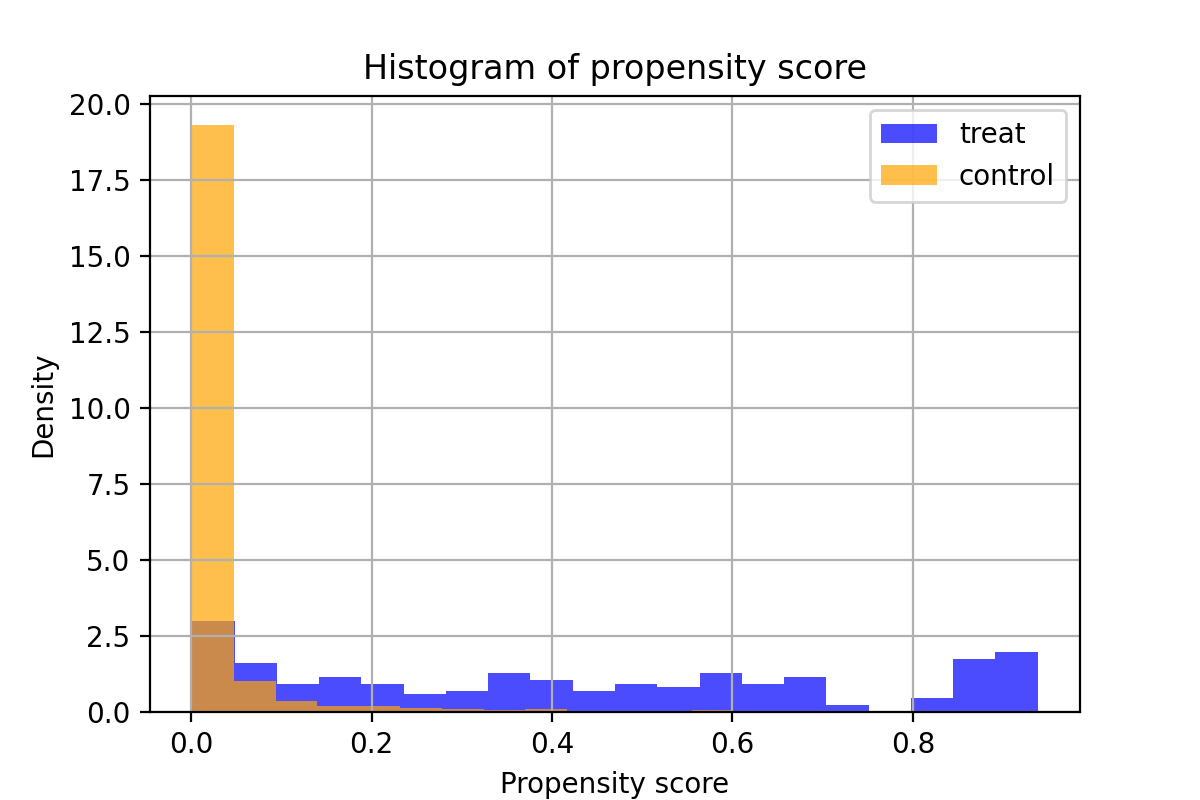

In [277]:
plot_map = {
    "treat": {
        "mask": mask_treat,
        "color": "blue"
    },
    "control": {
        "mask": mask_control,
        "color": "orange"
    }
}

make_hist(nsw_stacked, plot_map, "Propensity score")

Something's off with the propensity score 
Comparing to Dehejia/Wahba and to Cunningham:
- it should range to 0.9 for the treatment group, correspondingly the mean for the treatment group is too low 
- this also when directly running the code from Cunningham, see bottom of the notebook 
(I think the two issues have a different source since the samples are not exactly the same)

A note on assessing balance
- the propensity score is a nice summary of the balance, but makes assumptions about the functional form 
- common support -- see the assumptions for ATE (?)
- alternatively, we can plot differences in means, normalized variances and overlap in the tails to compare the groups

>Unlike CIA, the common support requirement is testable by simply plotting histograms or summarizing the data. Here we do that two ways: by looking at the summary statistics and by looking at a histogram. Let’s start with looking at a distribution in table form before looking at the histogram.



note that independence $\Rightarrow$ balance, so NOT balance $\Rightarrow$ NOT independence. but balance is of course not sufficient for independence.

So we have this huge imbalance. How can we fix it? 

do we even need the reweighting? or go straight to nearest-neighbor matching? why is re-weighting useful? 

also, can we use the ATE from the experiment with the matched estimator to illustrate the difference between the ATE and the ATT? does it not also matter what the population is we are referring to? ie, in the experiment, the ATE are the experimental units. in the matched estimate, the population is the universe of CPS respondents.


### Propensity score theorem
Assumptions
- conditional independence -- $(Y^1, Y^0) \perp\!\!\!\perp D | X $
- common support, so that we can estimate $E[Y^i | X_i = x]$ for all $x$ and for all $i$

Implication: conditioning on the propensity score is enough to recover the ATE $E[\delta_i (X_i)]$. Common support is necessary in order to estimate the propensity score (why exactly?), and conditional independence is necessary for the propensity score to be sufficient for controlling for all confounding.

Relation to the BLUE theorem in linear regression:
- conditioning on all the relevant indepdendent variables is enough to give you an unbiased estimate of $\beta$
- but, moreover, we have collapsed the matrix of Xs into a single number

**How can we use the propensity score**
- Reweighting 
- Subclassification
- Matching on the propensity score 

Imbens/Rubin prefer subclassification over reweighting because 
- propensity score is estimated with noise, and this enters the denominator in the reweighting schemes, creating bias 
- subclassification has smaller sampling variance because it smoothes over extreme values of the propensity score


### Subclassification on the propensity score

The idea is to create blocks of observations in the treatment and control group that have similar propensity scores. Then, take the difference in the outcome within those groups, and average the differences across groups to get an estimate of the ATE. In other words, we assume that there as a block-randomized experiment where treatment assignment was random within each block.

How do we find the blocks? Imbens/Rubin (chapter 17.3) propose the following algorithm
1. Start with a single block, with boundaries equal to 0 and 1
2. Compute 2 statistics to decide whether the block should be further splitted or not:
    - Compute t-statistic testing the H0 that the average value of the propensity score is the same in treatment and control groups. 
    - Compute the number of observations in treatment and control groups that would remain in two new blocks created by splitting the current block at the median of the propensity score 
3. While t-statistic > threshold and new block sizes sufficiently large:
    - Split the block
    - Update the statistics above 


We need to define the following parameters
- t_max = 1.96
- the minimum number of treated or control units in a new block
- the minimum number of units (T + C) in a new block

In [245]:
t_max = 1.96 
N_min1 = 3 
N_min2 = 2

In [246]:
nsw_stacked.head()
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,random,unemp74,unemp75,pscore
count,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,1.617700e+04
mean,0.011436,33.140507,12.008284,0.082339,0.071892,0.705755,0.300550,13880.469727,13512.212891,14749.482422,0.011436,0.126352,0.114916,1.143599e-02
std,0.106329,11.036508,2.868005,0.274889,0.258317,0.455717,0.458511,9613.115234,9313.207031,9670.996094,0.106329,0.332256,0.318931,6.910370e-02
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.176785e-09
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4075.274902,4103.418945,5492.709961,0.000000,0.000000,0.000000,1.957837e-05
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14892.389648,14374.500000,16240.219727,0.000000,0.000000,0.000000,1.246584e-04
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23491.609375,22830.189453,25564.669922,0.000000,0.000000,0.000000,1.057900e-03
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070312,25243.550781,60307.929688,1.000000,1.000000,1.000000,9.384554e-01


In [247]:
# we'll use the linearized propensity score instead 
nsw_stacked["lps"] = np.log(nsw_stacked["pscore"])
data = nsw_stacked.loc[:, ["treat", "lps"]].to_numpy()
b = np.ones((data.shape[0],1))
data = np.c_[data, b]

# compute the t-stat
W = data[:, 0] #treatment indicator

def summarise(a, block, W):
    """In a block for group W, compute:
    - the average propensity score
    - the number of observations
    - the within-group variance
    """
    # TODO: there are assumptions on which columns are which variable
    # perhaps just use vectors directly?

    N = np.sum(block * W)
    l = 1 / N * np.transpose(a[:, 1] * block).dot(W)
    sum_of_squared_diff = np.sum((a[:, 2] * block - l)**2)

    return l, N, sum_of_squared_diff

l_1, N_1, s2_1 = summarise(data, block=data[:, 2], W=W)
l_0, N_0, s2_0 = summarise(data, block=data[:, 2], W=np.ones(W.shape) - W)
s_hat = 1 / (N_1 + N_0 - 2) * (s2_0 + s2_1)

t_stat = (l_1 - l_0) / (np.sqrt(s_hat * (1 / N_1 + 1 / N_0)))

# count number of observation in a block if split by the median propensity score 
mid = np.median(data[:, 1])
block_a = data[:, 1] <= mid 
block_b = data[:, 1] > mid 

np.sum(data[:, 2] * block_a * W )
np.sum(data[:, 2] * block_a * (np.ones(W.shape) - W) )

np.sum(data[:, 2] * block_b * W )
# np.sum(data[:, 2] * block_b * (np.ones(W.shape) - W) )


185.0

### Matching on the propensity score

old stuff from Cunningham directly

In [140]:

nsw_dw = read_data('nsw_mixtape.dta')

mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.34


In [141]:


# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)


# continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol = nsw_dw_cpscontrol 
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))
        


nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))



nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (non-normalized, all data): -11535.55
Treatment Effect (normalized, all data): -7044.80
Treatment Effect (non-normalized, trimmed data): 2486.22
Treatment Effect (normalized, trimmed data): 423.62


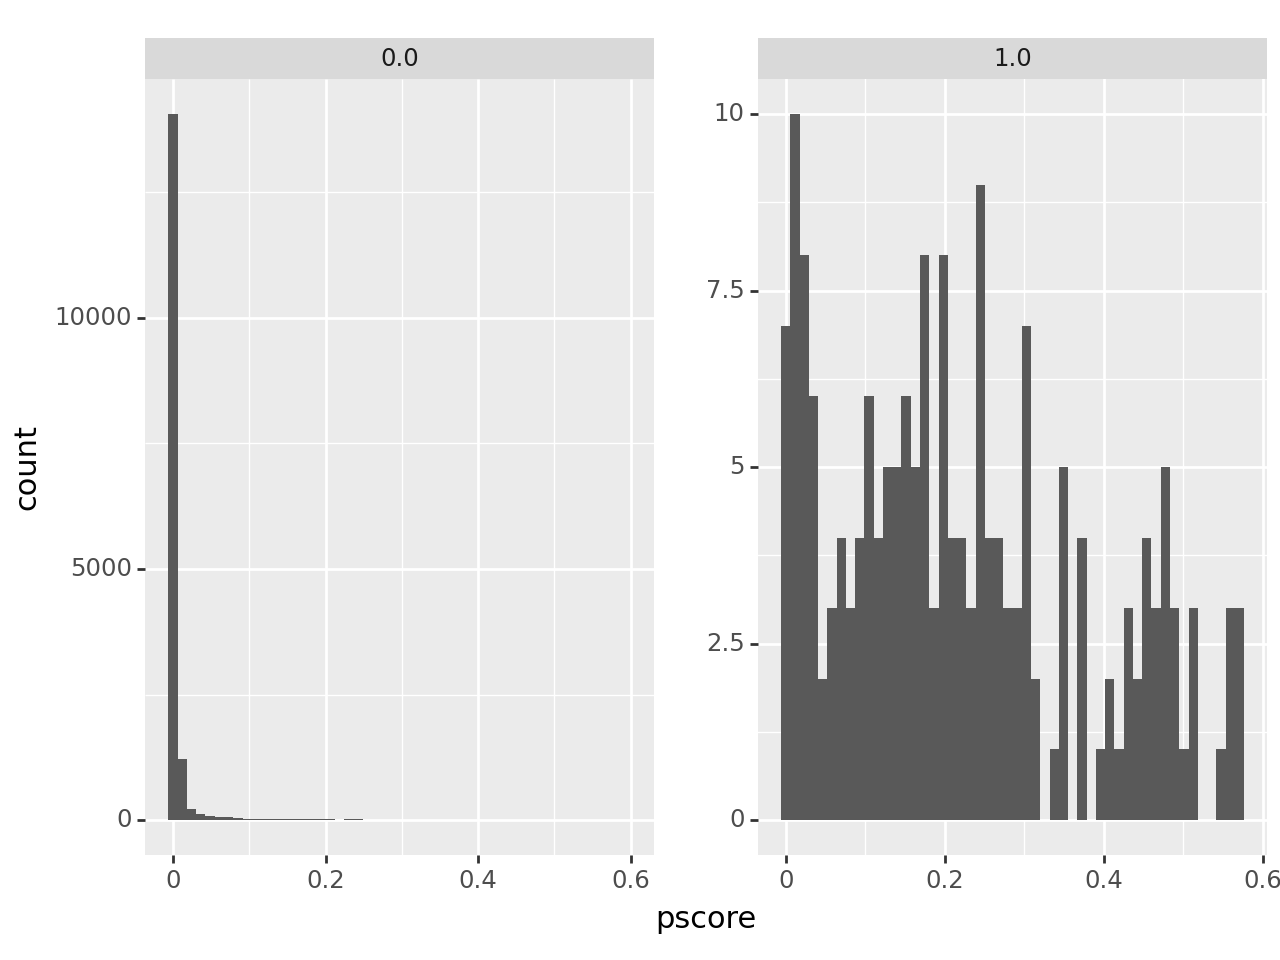

<Figure Size: (640 x 480)>

In [142]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)


# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol['u74'], nsw_dw_cpscontrol['u75'] = 0, 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) +    p.geom_histogram(bins=50) +    p.facet_wrap("treat", scales='free')

In [143]:
nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()


treat
0.0    0.008858
1.0    0.221850
Name: pscore, dtype: float64